In [1]:
import numpy as np
import TensorFrost as tf
import matplotlib.pyplot as plt

tf.initialize(tf.opengl)

def PrefixSum(A, axis = -1):
    axis = len(A.shape) + axis if axis < 0 else axis
    group_size = 128
    grouped = tf.split_dim(A, group_size, axis)
    group_scan = tf.prefix_sum(tf.sum(grouped, axis = axis + 1), axis = axis)
    ids = grouped.indices
    gid, eid = ids[axis], ids[axis + 1]
    ids = [ids[i] for i in range(len(ids)) if i != axis + 1]
    ids[axis] = gid - 1
    group_scan = tf.prefix_sum(grouped + tf.select((gid == 0) | (eid != 0), 0, group_scan[tuple(ids)]), axis = axis + 1)
    full_scan = tf.merge_dim(group_scan, target_size = A.shape[axis], axis = axis + 1)
    return full_scan

def RadixSort(keys, values, bits_per_pass = 4, max_bits = 32):
    iters = (max_bits + bits_per_pass - 1) // bits_per_pass
    group_size = 128
    histogram_size = 2 ** bits_per_pass

    def GetBits(A, i):
        return (A >> (i * bits_per_pass)) & (histogram_size - 1)
    
    keys1 = tf.buffer(keys.shape, keys.type)
    values1 = tf.buffer(values.shape, values.type)
    with tf.loop(iters // 2) as iter:
        def SortIteration(A, B, C, D, iter):
            tf.region_begin('SortIteration')
            grouped = tf.split_dim(GetBits(A, iter), group_size)
            g, e, i = tf.indices([grouped.shape[0], grouped.shape[1], histogram_size])
            is_bit = tf.select((grouped[g, e] == i) & ((g*group_size + e) < A.shape[0]), 1, 0)
            group_histogram = tf.sum(is_bit, axis = 1)
            group_histogram_scan = PrefixSum(group_histogram, axis = 0)
            i, = tf.indices([histogram_size])
            total_bit_histogram = tf.prefix_sum(group_histogram_scan[group_histogram_scan.shape[0] - 1, i])
            with tf.kernel(grouped.shape) as (g, e):
                element = g * group_size + e
                with tf.if_cond(element < A.shape[0]):
                    old_key = A[element]
                    old_val = C[element]
                    bit = GetBits(old_key, iter)
                    total_offset = tf.select(g == 0, 0, group_histogram_scan[g - 1, bit]) + tf.select(bit == 0, 0, total_bit_histogram[bit - 1])
                    with tf.loop(e) as j:
                        total_offset.val += tf.int(grouped[g, j] == bit)
                    B[total_offset] = old_key
                    D[total_offset] = old_val
            tf.region_end('SortIteration')

        SortIteration(keys, keys1, values, values1, 2 * iter)
        SortIteration(keys1, keys, values1, values, 2 * iter + 1)

    return keys, values

def BitonicSort(keys, values):
    tf.region_begin('Sort')
    element_count = keys.shape[0]
    log2N = tf.ceil(tf.log2(tf.float(element_count)))
    Nround = tf.int(tf.exp2(log2N))
    sort_id = tf.indices([Nround/2])[0]
    steps = tf.int(log2N*(log2N + 1.0)/2.0)

    with tf.loop(steps) as step:
        def getBitonicElementPair(id, step):
            j = tf.floor(tf.sqrt(tf.float(2*step) + 1.0) - 0.5)
            n = tf.round(tf.float(step) - 0.5*j*(j+1.0))
            B = tf.int(tf.round(tf.exp2(j-n)))
            mask = tf.select(n < 0.5, 2*B - 1, B)
            e1 = id%B + 2*B*(id/B)
            e2 = e1 ^ mask
            return e1, e2
        e1, e2 = getBitonicElementPair(sort_id, step)

        with tf.if_cond((e1 < element_count) & (e2 < element_count)):
            key1, key2 = keys[e1], keys[e2]

            with tf.if_cond(key1 > key2):
                val1, val2 = values[e1], values[e2]
                keys[e1] = key2
                keys[e2] = key1
                values[e1] = val2
                values[e2] = val1

    tf.region_end('Sort')
    return keys, values

def Sort0():
    keys = tf.input([-1], tf.int32)
    values = tf.input([-1], tf.int32)
    sorted_keys, sorted_values = RadixSort(keys, values)
    return sorted_keys, sorted_values

sort_program0 = tf.compile(Sort0)

def Sort1():
    keys = tf.input([-1], tf.int32)
    values = tf.input([-1], tf.int32)
    sorted_keys, sorted_values = BitonicSort(keys, values)
    return sorted_keys, sorted_values

sort_program1 = tf.compile(Sort1)

TensorFrost module loaded!
Sort0:
  Kernel count: 12
  Intermediate buffers: 12
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 531
  IR Compile time: 25.082001 ms
  Steps time: 2200.502197 ms

Sort1:
  Kernel count: 1
  Intermediate buffers: 0
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 491
  IR Compile time: 2.930100 ms
  Steps time: 1557.253174 ms



Radix sort error: 0
Bitonic sort error: 0


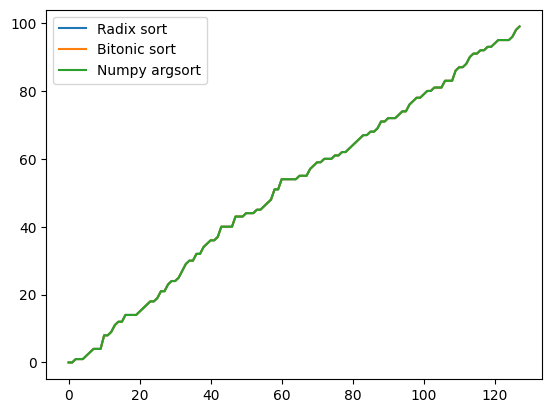

In [2]:
# Generate some random data to scan (ints between 0 and 10)
keys = np.random.randint(0, 100, 128).astype(np.int32)
values = np.random.randint(0, 100, 128).astype(np.int32)

tf.renderdoc_start_capture()

# do sort in TensorFrost
sorted_keys0, sorted_values0 = sort_program0(keys, values)
sorted_keys1, sorted_values1 = sort_program1(keys, values)

tf.renderdoc_end_capture()

# do argsort in numpy
sorted_indices = np.argsort(keys)
sorted_keys2 = keys[sorted_indices]
sorted_values2 = values[sorted_indices]

# check if the results are the same
error_radix = np.sum(np.abs(sorted_keys0.numpy - sorted_keys2))
error_bitonic = np.sum(np.abs(sorted_keys1.numpy - sorted_keys2))
print('Radix sort error:', error_radix)
print('Bitonic sort error:', error_bitonic)

# plot the results
plt.figure()
plt.plot(sorted_keys0.numpy, label='Radix sort')
plt.plot(sorted_keys1.numpy, label='Bitonic sort')
plt.plot(sorted_keys2, label='Numpy argsort')
plt.legend()
plt.show()
